# Model Performance Evaluation Report

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

# Adjust pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Matplotlib style
plt.style.use('ggplot')

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Data and Models

In [2]:
# Define paths (adjust if your notebook is in a different location relative to models/data)
DATA_FILE = '../data/multi_class_station_data.csv'
CLASSIFIER_PATH = '../models/maintenance_type_classifier.joblib'
REGRESSOR_PATH = '../models/maintenance_day_regressor.joblib'

# Load data
try:
    df = pd.read_csv(DATA_FILE)
    print(f"Data loaded successfully from {DATA_FILE}. Shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE}. Please check the path.")
    df = None

# Load models
if df is not None:
    try:
        classifier_model = joblib.load(CLASSIFIER_PATH)
        print(f"Classifier model loaded successfully from {CLASSIFIER_PATH}")
    except FileNotFoundError:
        print(f"Error: Classifier model not found at {CLASSIFIER_PATH}. Please check the path.")
        classifier_model = None

    try:
        regressor_model = joblib.load(REGRESSOR_PATH)
        print(f"Regressor model loaded successfully from {REGRESSOR_PATH}")
    except FileNotFoundError:
        print(f"Error: Regressor model not found at {REGRESSOR_PATH}. Please check the path.")
        regressor_model = None
else:
    classifier_model = None
    regressor_model = None

Data loaded successfully from ../data/multi_class_station_data.csv. Shape: (5000, 8)


,location,temperature,charging_sessions_last_30d,firmware_version,cable_wear_indicator,voltage_instability_index,maintenance_type,next_maintenance_days
0,Location C,32.17,54,v2.0,0.39,1.11,No Maintenance Needed,340.04
1,Location D,33.16,75,v2.1,0.54,0.54,Connector Cleaning/Repair,26.92
2,Location A,32.44,59,v2.0,0.61,0.38,No Maintenance Needed,354.14
3,Location C,28.72,73,v1.2,0.15,2.56,Power Supply Unit Fault,4.08
4,Location C,26.42,60,v2.0,0.42,0.54,No Maintenance Needed,247.90


Classifier model loaded successfully from ../models/maintenance_type_classifier.joblib
Regressor model loaded successfully from ../models/maintenance_day_regressor.joblib


## 3. Prepare Data for Evaluation
We need to split the data into training and testing sets, similar to how it was done during training, to evaluate the models on unseen data.

In [3]:
if df is not None:
    # Prepare data for Classifier Evaluation
    X_clf = df.drop(columns=['maintenance_type', 'next_maintenance_days'])
    y_clf = df['maintenance_type']
    # Use the same random_state and test_size as in training for consistency in evaluation
    _, X_test_clf, _, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.25, random_state=42, stratify=y_clf)
    print("Data prepared for classifier evaluation.")
    print(f"X_test_clf shape: {X_test_clf.shape}, y_test_clf shape: {y_test_clf.shape}")

    # Prepare data for Regressor Evaluation
    # The regressor uses 'maintenance_type' as a feature. We'll use the true maintenance_type from the test set.
    X_reg = df.drop(columns=['next_maintenance_days'])
    y_reg = df['next_maintenance_days']
    _, X_test_reg, _, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)
    print("\nData prepared for regressor evaluation.")
    print(f"X_test_reg shape: {X_test_reg.shape}, y_test_reg shape: {y_test_reg.shape}")
else:
    print("Dataframe not loaded, skipping data preparation.")

Data prepared for classifier evaluation.
X_test_clf shape: (1250, 6), y_test_clf shape: (1250,)

Data prepared for regressor evaluation.
X_test_reg shape: (1250, 7), y_test_reg shape: (1250,)


## 4. Maintenance Type Classifier Evaluation

--- Evaluating Maintenance Type Classifier ---

Classification Report:
                              precision    recall  f1-score   support

Cable Inspection/Replacement       0.99      0.97      0.98       120
   Connector Cleaning/Repair       0.99      1.00      1.00       107
       No Maintenance Needed       1.00      1.00      1.00       650
     Power Supply Unit Fault       1.00      0.98      0.99        62
       Software Update/Reset       1.00      1.00      1.00       311

                    accuracy                           1.00      1250
                   macro avg       1.00      0.99      0.99      1250
                weighted avg       1.00      1.00      1.00      1250



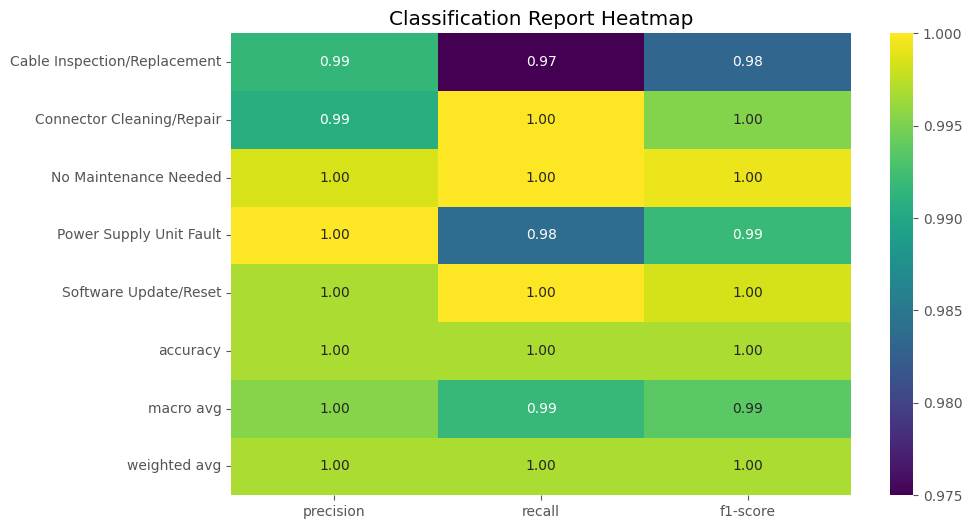


Confusion Matrix:


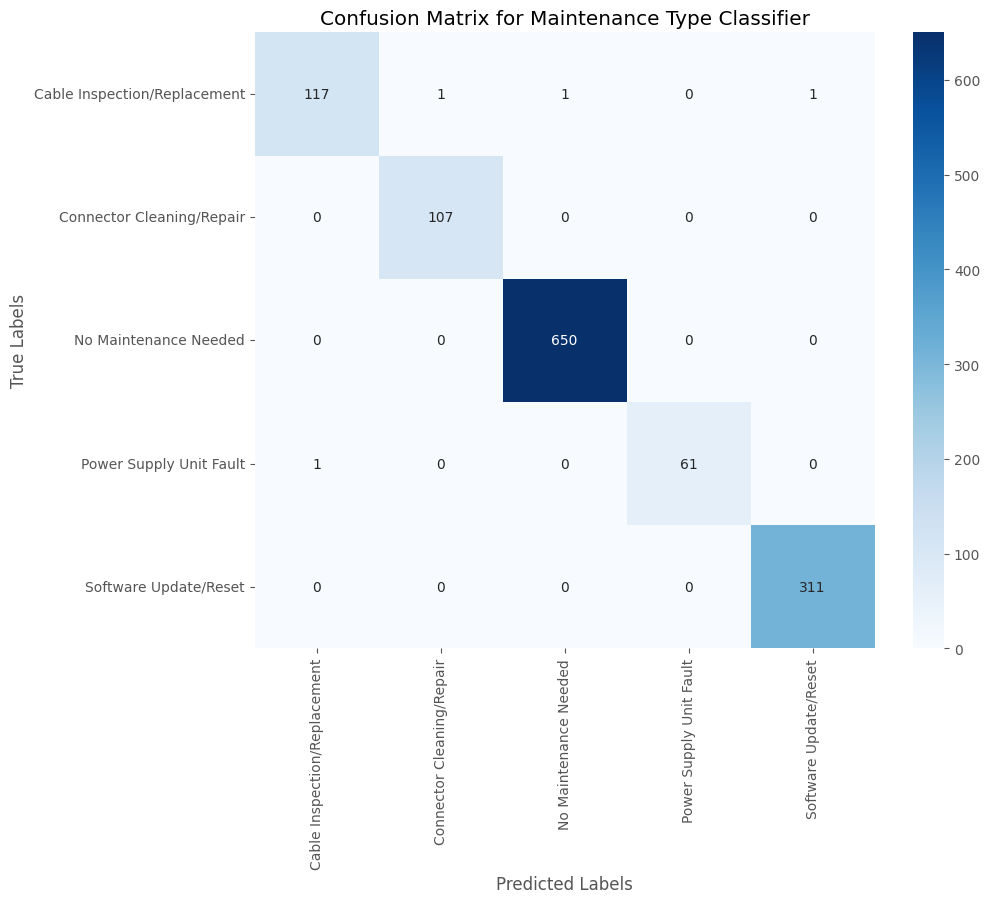

C:\Users\tarun\AppData\Local\Temp\ipykernel_24608\3163507962.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=clf_importance_df.head(15), palette='mako')


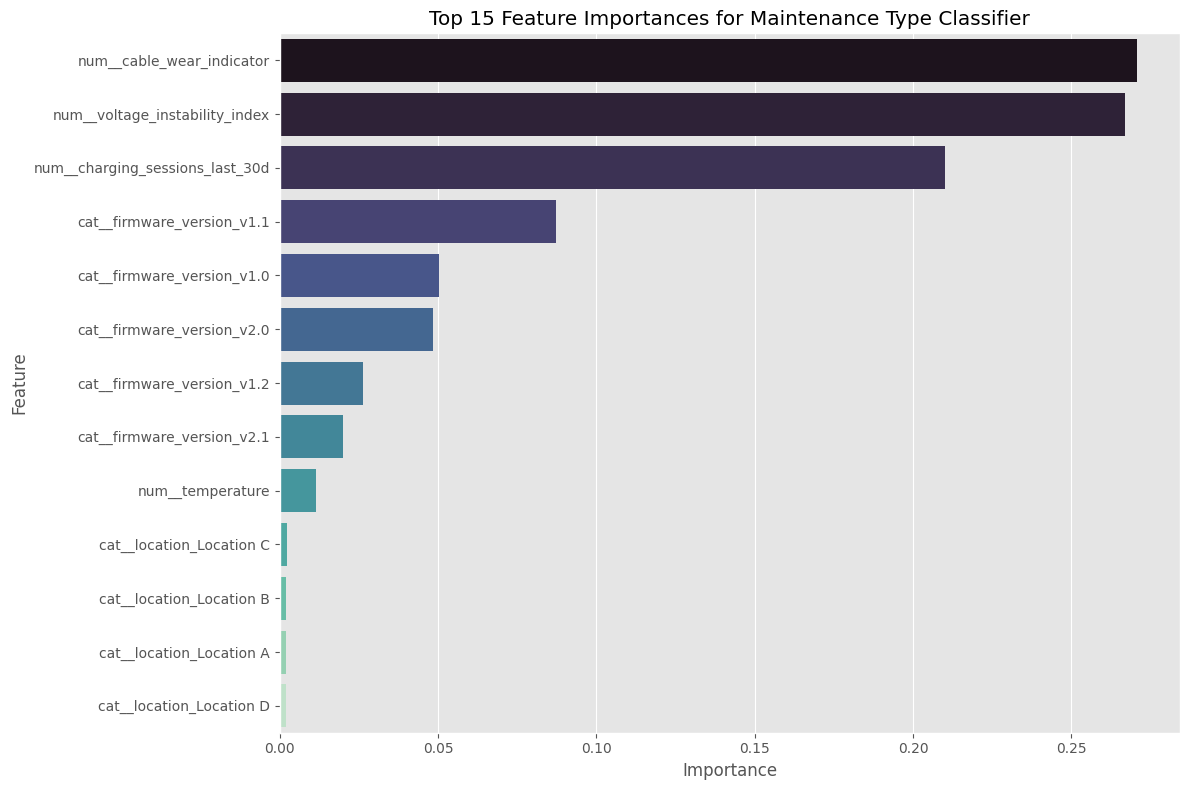

In [4]:
if classifier_model and df is not None:
    print("--- Evaluating Maintenance Type Classifier ---")
    y_pred_clf = classifier_model.predict(X_test_clf)
    
    print("\nClassification Report:")
    report_clf = classification_report(y_test_clf, y_pred_clf, output_dict=True)
    print(classification_report(y_test_clf, y_pred_clf))
    
    # Plotting Classification Report as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(report_clf).iloc[:-1, :].T, annot=True, cmap="viridis", fmt='.2f')
    plt.title('Classification Report Heatmap')
    plt.show()
    
    print("\nConfusion Matrix:")
    cm_clf = confusion_matrix(y_test_clf, y_pred_clf)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_clf, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_model.classes_, yticklabels=classifier_model.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Maintenance Type Classifier')
    plt.show()

    # Feature Importances for Classifier
    try:
        actual_classifier = classifier_model.named_steps['classifier']
        preprocessor_clf = classifier_model.named_steps['preprocessor']
        feature_names_clf = preprocessor_clf.get_feature_names_out()
        importances_clf = actual_classifier.feature_importances_
        
        clf_importance_df = pd.DataFrame({
            'Feature': feature_names_clf,
            'Importance': importances_clf
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=clf_importance_df.head(15), palette='mako')
        plt.title('Top 15 Feature Importances for Maintenance Type Classifier')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not display classifier feature importances: {e}")
else:
    print("Classifier model or data not loaded, skipping classifier evaluation.")

## 5. Next Maintenance Day Regressor Evaluation

--- Evaluating Next Maintenance Day Regressor ---

Root Mean Squared Error (RMSE): 37.82 days
R-squared (R2) Score: 0.91


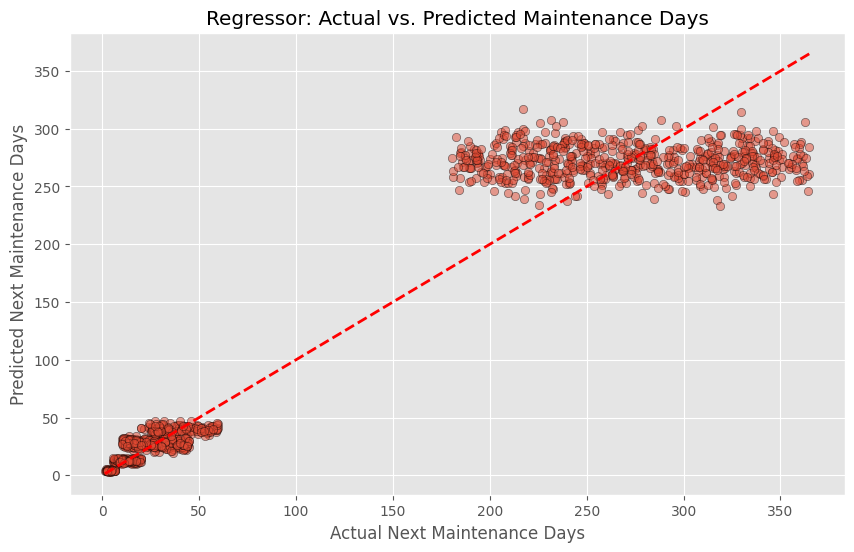

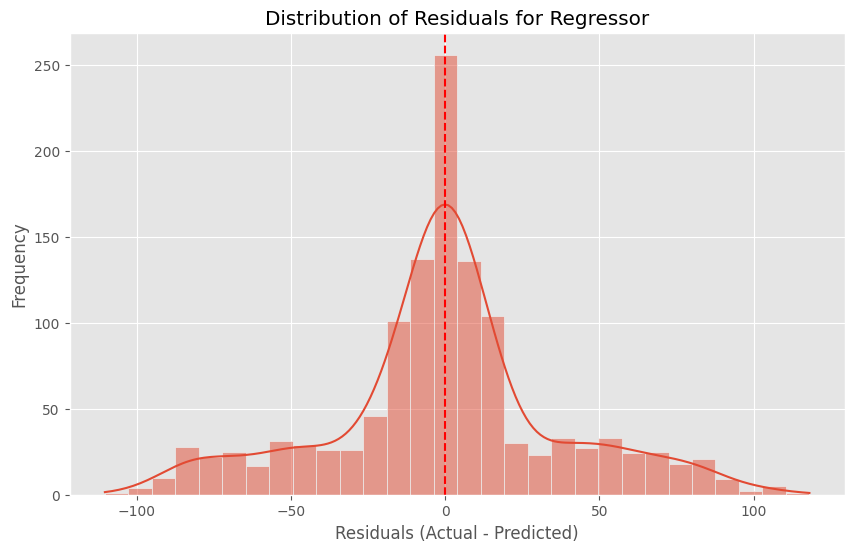

C:\Users\tarun\AppData\Local\Temp\ipykernel_24608\250431327.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=reg_importance_df.head(15), palette='viridis')


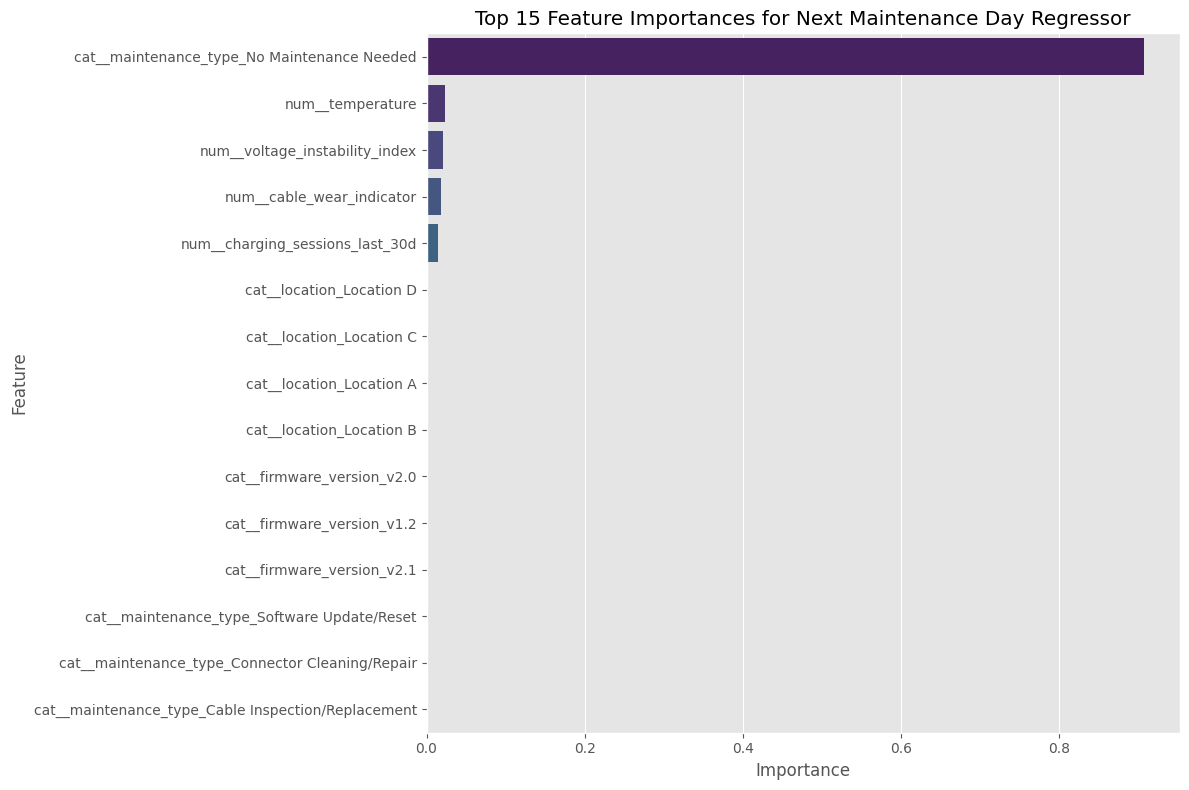

In [5]:
if regressor_model and df is not None:
    print("--- Evaluating Next Maintenance Day Regressor ---")
    y_pred_reg = regressor_model.predict(X_test_reg)
    
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f} days")
    print(f"R-squared (R2) Score: {r2:.2f}")
    
    # Scatter plot of Actual vs. Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, edgecolors='k')
    plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
    plt.xlabel('Actual Next Maintenance Days')
    plt.ylabel('Predicted Next Maintenance Days')
    plt.title('Regressor: Actual vs. Predicted Maintenance Days')
    plt.show()
    
    # Distribution of Residuals
    residuals = y_test_reg - y_pred_reg
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals for Regressor')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    # Feature Importances for Regressor
    try:
        actual_regressor = regressor_model.named_steps['regressor']
        preprocessor_reg = regressor_model.named_steps['preprocessor']
        feature_names_reg = preprocessor_reg.get_feature_names_out()
        importances_reg = actual_regressor.feature_importances_
        
        reg_importance_df = pd.DataFrame({
            'Feature': feature_names_reg,
            'Importance': importances_reg
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=reg_importance_df.head(15), palette='viridis')
        plt.title('Top 15 Feature Importances for Next Maintenance Day Regressor')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not display regressor feature importances: {e}")
else:
    print("Regressor model or data not loaded, skipping regressor evaluation.")

## 6. Conclusion
This notebook provided an evaluation of the trained classification and regression models. Key metrics and visualizations were generated to assess their performance on unseen test data. The feature importances highlight the key drivers for each model's predictions.